In [1]:
%pylab nbagg
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wilson_cowan.WilsonCowan.state_variable_range = Const(field_type=<type 'dict'>, default={'I': array([0., 1.]), 'E': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Const(field_type=<type 'dict'>, default={'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.]), 'xi': array([-4.,  4.]), 'eta': array([-3.,  3.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.state_variable_range = Const(field_type=<type 'dict'>, default={'tau': array([ 2., 10.]), 'x

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.hopfield.Hopfield.state_variable_range = Const(field_type=<type 'dict'>, default={'x': array([-1.,  2.]), 'theta': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Const(field_type=<type 'dict'>, default={'y2': array([0., 2.]), 'g': array([-1.,  1.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y1': array([-20.,   2.]), 'x1': array([-2.,  1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Const(field_type=<type 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required=True)
WARNING  default contains values out of the declared domain. 

//anaconda/envs/tvb_library_git/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# Simulate cortical surface with s/M/EEG forward solutions

Cortical surface with subcortical regions, sEEG, EEG & MEG, using a stochastic
integration.

In [2]:
from tvb.datatypes.cortex import Cortex
from tvb.datatypes.region_mapping import RegionMapping
from tvb.datatypes.projections import ProjectionMatrix, ProjectionSurfaceEEG
from tvb.datatypes.sensors import SensorsEEG

oscillator = models.Generic2dOscillator(a=numpy.array([0.1]), tau=numpy.array([2.0]))

white_matter = connectivity.Connectivity.from_file('connectivity_192.zip')
white_matter.speed = numpy.array([4.0])
white_matter_coupling = coupling.Difference(a=numpy.array([0.014]))

rm = RegionMapping.from_file('regionMapping_16k_192.txt')
sensorsEEG = SensorsEEG.from_file('eeg_unitvector_62.txt.bz2')
prEEG = ProjectionSurfaceEEG.from_file('projection_eeg_62_surface_16k.mat', matlab_data_name="ProjectionMatrix")

heunint = integrators.HeunStochastic(
    dt=2**-4,
    noise=noise.Additive(nsig=numpy.array([2 ** -5, ]))
)

fsamp = 1e3/1024.0 # 1024 Hz
# See shown here 3 different ways of configuring monitors.
# These methods are available for all projection monitors
monitor_MEG=monitors.MEG.from_file()
monitor_MEG.period=fsamp
mons = (
    monitors.EEG(sensors=sensorsEEG, projection=prEEG, region_mapping=rm, period=fsamp),
    monitor_MEG,
    monitors.iEEG.from_file('seeg_588.txt', 'projection_seeg_588_surface_16k.npy', period=fsamp),
    monitors.ProgressLogger(period=100.0),
)

local_coupling_strength = numpy.array([2 ** -10])
region_mapping_data=RegionMapping.from_file('regionMapping_16k_192.txt')
default_cortex = Cortex.from_file()
default_cortex.region_mapping_data = region_mapping_data
default_cortex.coupling_strength = local_coupling_strength

sim = simulator.Simulator(
    model=oscillator,
    connectivity=white_matter,
    coupling=white_matter_coupling,
    integrator=heunint,
    monitors=mons,
    surface=default_cortex,
    simulation_length=1000.0
).configure()

eeg, meg, seeg, _ = sim.run()

WARNING  File 'hemispheres' not found in ZIP.


/WORK/TVB_GIT/tvb-library/tvb/basic/readers.py:125: RuntimeWarning: Assuming latin1 encoding for bz2 text file in Python2
  array_result = numpy.loadtxt(file_stream, dtype=dtype, skiprows=skip_rows, usecols=use_cols)
/WORK/TVB_GIT/tvb-library/tvb/simulator/monitors.py:676: RuntimeWarning: invalid value encountered in divide
  sensor_locations = sensor_locations / sen_dis[:, numpy.newaxis]
/WORK/TVB_GIT/tvb-library/tvb/simulator/monitors.py:691: RuntimeWarning: divide by zero encountered in divide
  B_r[sensor_k, :] = ((mu_0 / (4.0 * numpy.pi * F**2)) *
/WORK/TVB_GIT/tvb-library/tvb/simulator/monitors.py:693: RuntimeWarning: invalid value encountered in multiply
  (rsk * delF), axis=1)[:, numpy.newaxis]))


WARNING  Memory estimate exceeds total available RAM.
   INFO  step 1 time 0.0001 s
   INFO  step 1601 time 0.1001 s
   INFO  step 3201 time 0.2001 s
   INFO  step 4801 time 0.3001 s
   INFO  step 6401 time 0.4001 s
   INFO  step 8001 time 0.5001 s
   INFO  step 9601 time 0.6001 s
   INFO  step 11201 time 0.7001 s
   INFO  step 12801 time 0.8001 s
   INFO  step 14401 time 0.9001 s


<IPython.core.display.Javascript object>


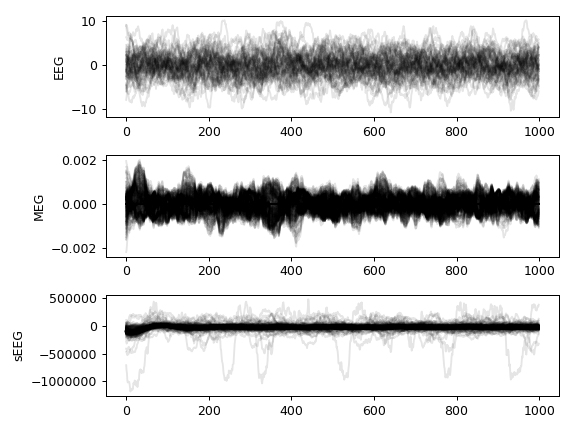

In [3]:
figure()

for i, mon in enumerate((eeg, meg, seeg)):
    subplot(3, 1, i + 1)
    time, data = mon
    plot(time, data[:, 0, :, 0], 'k', alpha=0.1)
    ylabel(['EEG', 'MEG', 'sEEG'][i])

tight_layout()